# Exogenous Variables (30-day Resample): Time Series Analysis

If we decide to use exogenous variables to fit our model and predict ADP in the future, we will need to predict the values of these variables in order have inputs for our predictive model. Therefore, we need to analyze the trends of the exogenous variables so we can determine how to predict the twelve future values.

Our exogenous variables are:

* admission and discharge counts

* average length of stay

* felony crime counts

* felony arrest counts

These datasets seem to be about a month behind the DOC Daily Inmates in Custody dataset. Thus, we will need to adjust for any missing data *AND* use an ARIMA model to extend our 30-day periods to be compatible with our ADP data and the DOC exogenous variables.

This notebook will analyze the trends in the 30 day time series signals collected in `01_get_data.ipynb`. 

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.api import SARIMAX
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from functions import *
%matplotlib inline

## Step 1: Import Data

This data was saved in `01_get_data.ipynb`

In [77]:
_30day_pop_tot = pd.read_csv("../Data/_30_day_adp.csv", index_col = 0)
#specify data types for start and end date
_30day_pop_tot['Start Date'] = _30day_pop_tot['Start Date'].astype('datetime64[ns]')
_30day_pop_tot['End Date'] = _30day_pop_tot['End Date'].astype('datetime64[ns]')

_30day_pop_tot.head()

,Start Date,End Date,ADP
0,2016-05-16,2016-06-14,9821.0
1,2016-06-15,2016-07-14,9792.0
2,2016-07-15,2016-08-13,9732.0
3,2016-08-14,2016-09-12,9830.0
4,2016-09-13,2016-10-12,9840.0


In [78]:
#look at the last 30-day period
_30day_pop_tot.tail(1)

,Start Date,End Date,ADP
97,2024-05-04,2024-06-02,6317.0


In [79]:
joined_doc_ivs_df = pd.read_csv("../Data/_30_day_IVs.csv", index_col = 0)
#specify data types for start and end date
joined_doc_ivs_df['Start Date'] = joined_doc_ivs_df['Start Date'].astype('datetime64[ns]')
joined_doc_ivs_df['End Date'] = joined_doc_ivs_df['End Date'].astype('datetime64[ns]')
joined_doc_ivs_df.head()

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days
0,2016-05-16,2016-06-14,4961,5036,57.516161
1,2016-06-15,2016-07-14,4918,5011,63.843071
2,2016-07-15,2016-08-13,4846,4725,59.396913
3,2016-08-14,2016-09-12,4578,4452,57.784929
4,2016-09-13,2016-10-12,4572,4692,60.720000


In [80]:
#look at the last 30-day period
joined_doc_ivs_df.tail(1)

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days
96,2024-04-04,2024-05-03,1959,1981,101.029263


In [81]:
crime_data = pd.read_csv("../Data/_30_day_crime_counts.csv", index_col = 0)
#specify data types for start and end date
crime_data['Start Date'] = crime_data['Start Date'].astype('datetime64[ns]')
crime_data['End Date'] = crime_data['End Date'].astype('datetime64[ns]')

#get arrest data
arrest_data = pd.read_csv("../Data/_30_day_arrest_counts.csv", index_col = 0)
#specify data types for start and end date
arrest_data['Start Date'] = arrest_data['Start Date'].astype('datetime64[ns]')
arrest_data['End Date'] = arrest_data['End Date'].astype('datetime64[ns]')


In [82]:
crime_data.head()

,Start Date,End Date,total_felony_crimes,murder_homicide_count,robbery_count,assault_count,burglary_count,rape_count,grand_larceny_count,grand_larceny_vehicle_count,weapons_count
0,2016-05-16,2016-06-14,12507,30,1279,1854,1063,133,3650,593,470
1,2016-06-15,2016-07-14,12820,32,1291,1966,1070,141,3824,563,420
2,2016-07-15,2016-08-13,13099,48,1362,2076,1128,149,3802,629,382
3,2016-08-14,2016-09-12,13224,35,1362,1969,1115,122,3804,648,497
4,2016-09-13,2016-10-12,12372,33,1334,1673,1076,113,3654,552,466


In [83]:
arrest_data.head()

,Start Date,End Date,total_felony_arrest,arrest_murder_homicide_count,arrest_robbery_count,arrest_assault_count,arrest_burglary_count,arrest_rape_count,arrest_grand_larceny_count,arrest_grand_larceny_vehicle_count,arrest_weapons_count
0,2016-05-16,2016-06-14,8004,72,875,1357,411,73,872,93,620
1,2016-06-15,2016-07-14,7661,94,791,1392,328,68,848,104,576
2,2016-07-15,2016-08-13,7756,109,852,1400,377,76,787,84,501
3,2016-08-14,2016-09-12,7808,73,835,1365,418,69,821,101,629
4,2016-09-13,2016-10-12,7767,83,908,1157,444,58,787,115,593


In [84]:
print(crime_data.tail(1)[['Start Date', 'End Date']])
print(arrest_data.tail(1)[['Start Date', 'End Date']])

   Start Date   End Date
94 2024-02-04 2024-03-04
   Start Date   End Date
94 2024-02-04 2024-03-04


As described above, the arrest and crime data are one data point behind the DOC data sets. We will need to find the best way to account for this missing data point. Since we are going to analyze the trends of each exogenous variable and use an ARIMA model to predict 12 future time periods, we might as well use the ARIMA model to predict the missing data point.

In [85]:
# Combine the dataframes into one big dataframe
exog_combined = pd.concat([joined_doc_ivs_df.iloc[:-1], crime_data[crime_data.columns.to_list()[2:]], arrest_data[arrest_data.columns.to_list()[2:]]], axis=1)
exog_combined.head()

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days,total_felony_crimes,murder_homicide_count,robbery_count,assault_count,burglary_count,...,weapons_count,total_felony_arrest,arrest_murder_homicide_count,arrest_robbery_count,arrest_assault_count,arrest_burglary_count,arrest_rape_count,arrest_grand_larceny_count,arrest_grand_larceny_vehicle_count,arrest_weapons_count
0,2016-05-16,2016-06-14,4961,5036,57.516161,12507.0,30.0,1279.0,1854.0,1063.0,...,470.0,8004.0,72.0,875.0,1357.0,411.0,73.0,872.0,93.0,620.0
1,2016-06-15,2016-07-14,4918,5011,63.843071,12820.0,32.0,1291.0,1966.0,1070.0,...,420.0,7661.0,94.0,791.0,1392.0,328.0,68.0,848.0,104.0,576.0
2,2016-07-15,2016-08-13,4846,4725,59.396913,13099.0,48.0,1362.0,2076.0,1128.0,...,382.0,7756.0,109.0,852.0,1400.0,377.0,76.0,787.0,84.0,501.0
3,2016-08-14,2016-09-12,4578,4452,57.784929,13224.0,35.0,1362.0,1969.0,1115.0,...,497.0,7808.0,73.0,835.0,1365.0,418.0,69.0,821.0,101.0,629.0
4,2016-09-13,2016-10-12,4572,4692,60.720000,12372.0,33.0,1334.0,1673.0,1076.0,...,466.0,7767.0,83.0,908.0,1157.0,444.0,58.0,787.0,115.0,593.0


In [86]:
exog_combined.tail(1)

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days,total_felony_crimes,murder_homicide_count,robbery_count,assault_count,burglary_count,...,weapons_count,total_felony_arrest,arrest_murder_homicide_count,arrest_robbery_count,arrest_assault_count,arrest_burglary_count,arrest_rape_count,arrest_grand_larceny_count,arrest_grand_larceny_vehicle_count,arrest_weapons_count
95,2024-03-05,2024-04-03,2002,1983,98.22267,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot Exogenous Variables to help visualize trends over time

In [57]:
import matplotlib.gridspec as gridspec

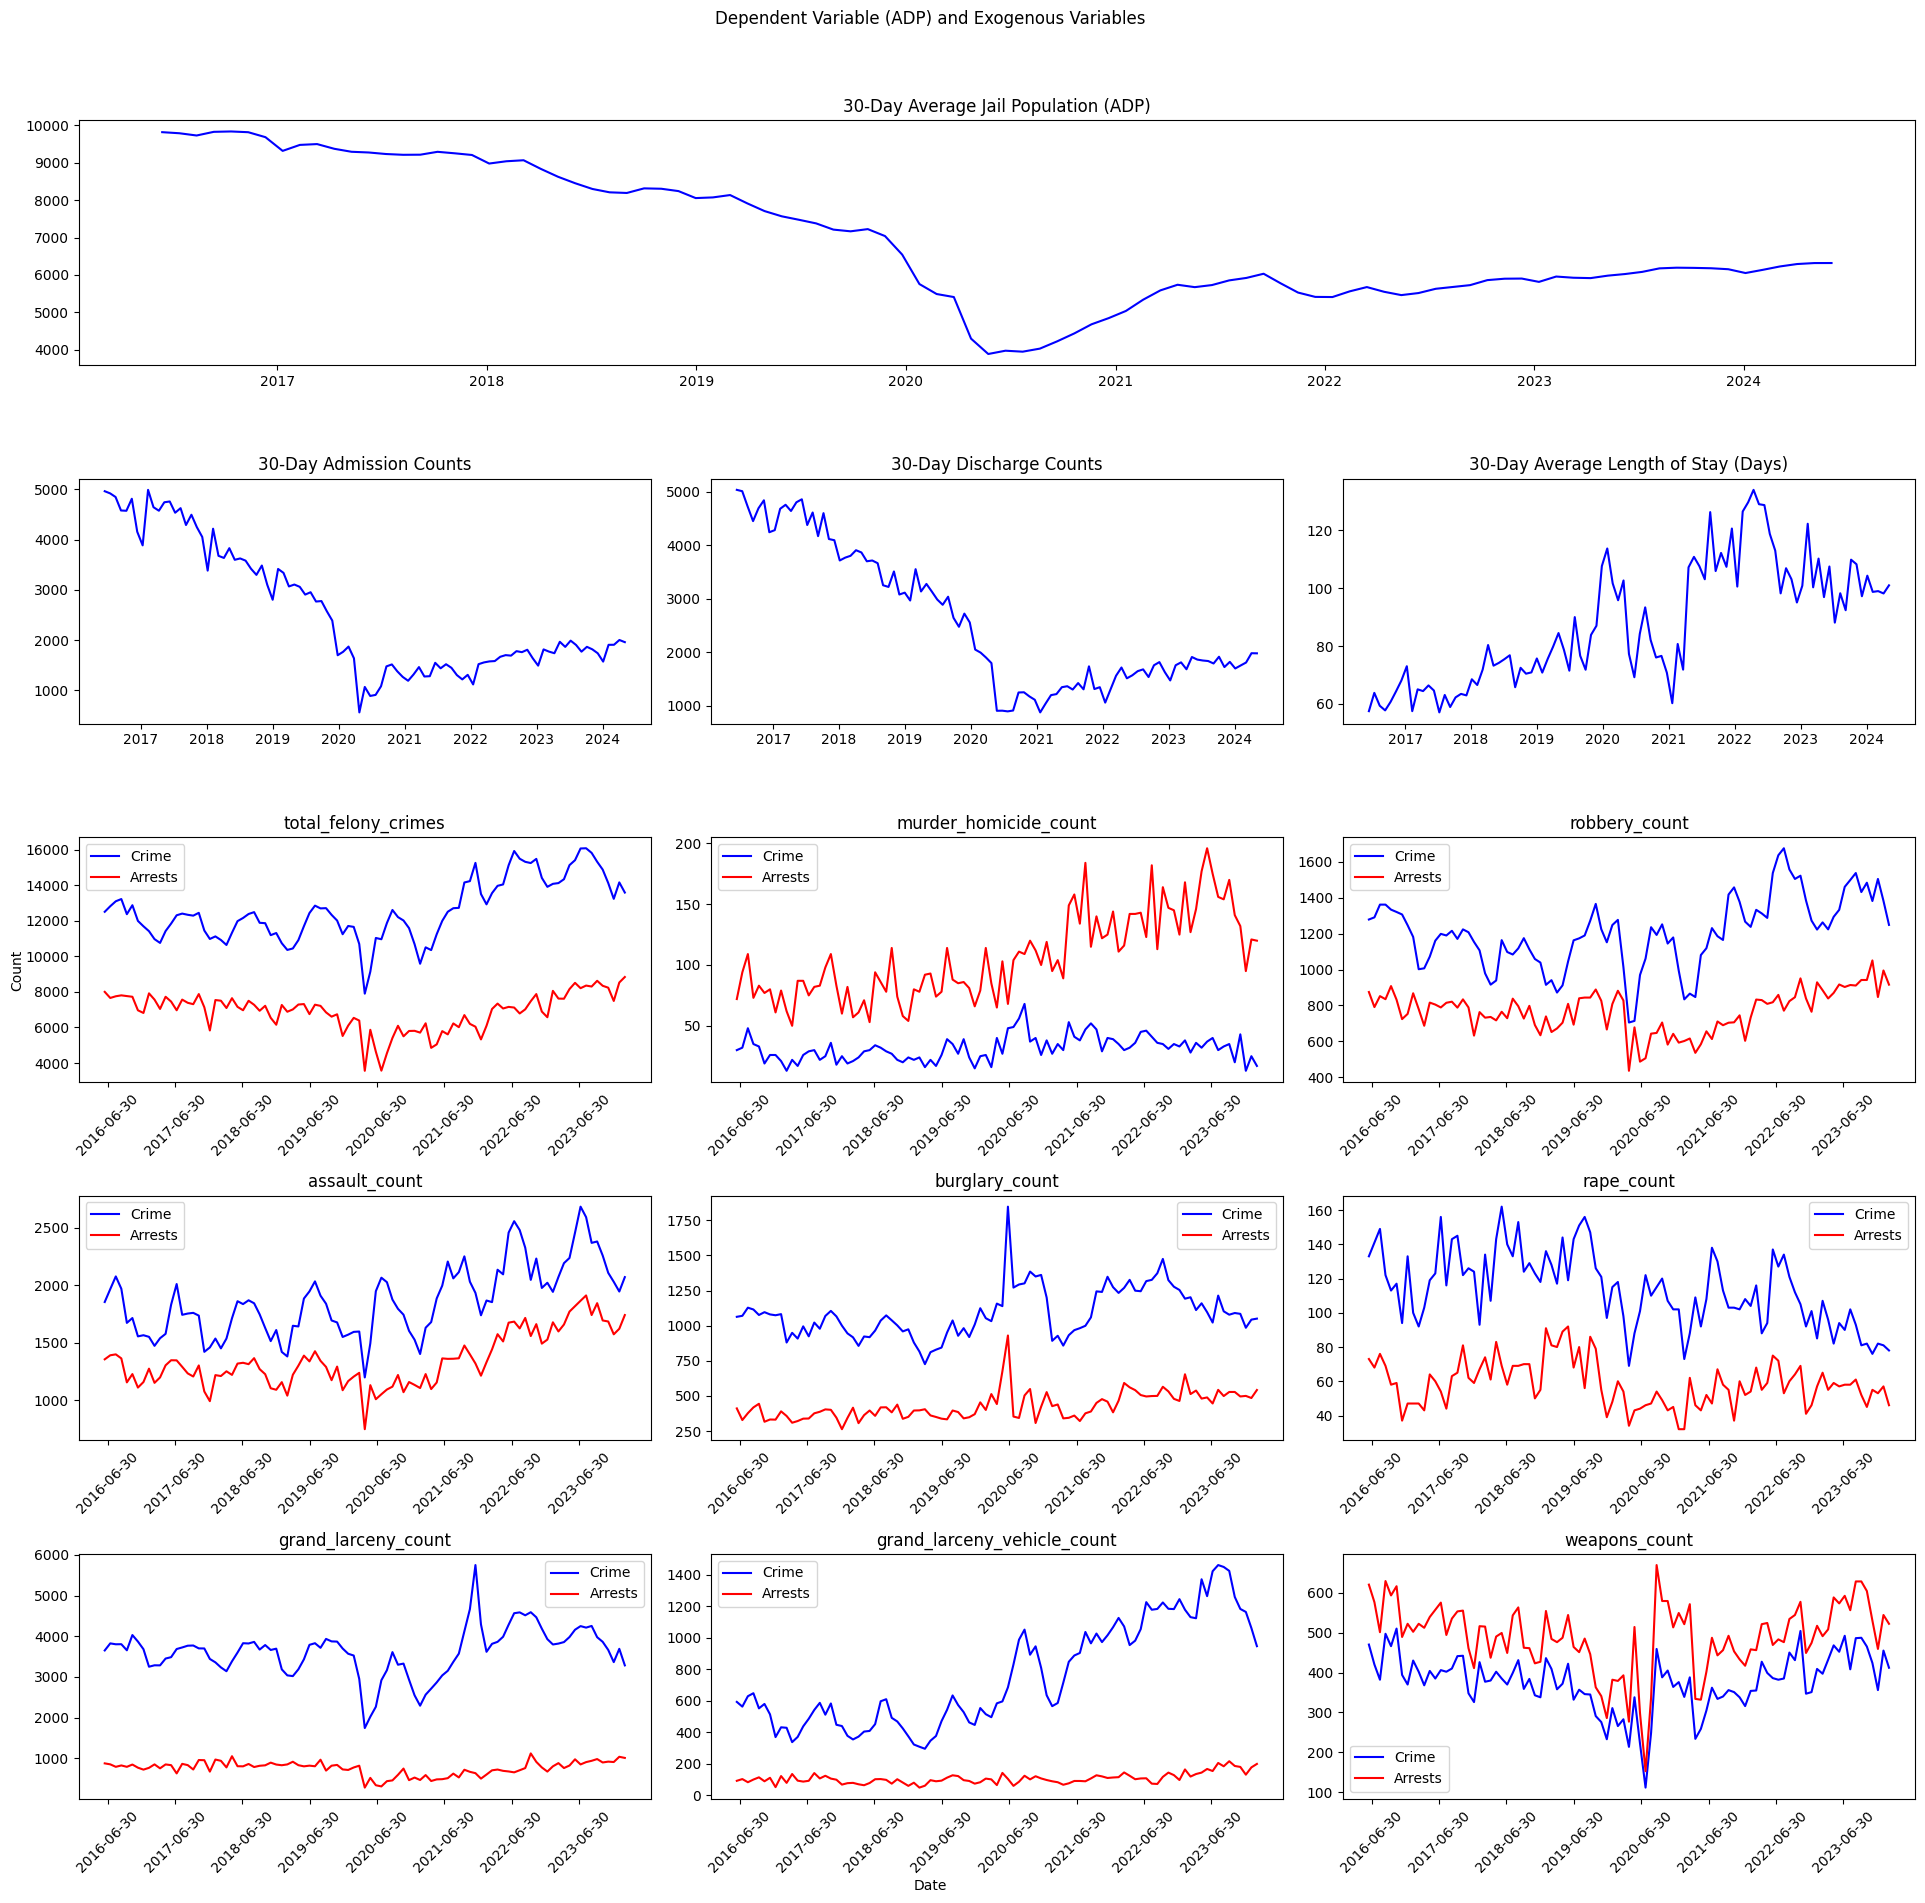

In [14]:
# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(5, 3, figure=fig)

# ADP vs End Date (spanning all three columns in the first row)
ax0 = fig.add_subplot(gs[0, :])
ax0.plot(_30day_pop_tot['End Date'], _30day_pop_tot['ADP'], 'b', label='ADP')
ax0.set_title('30-Day Average Jail Population (ADP)')

# admission_count, discharge_count, los_days vs End Date in the second row
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(joined_doc_ivs_df['End Date'], joined_doc_ivs_df['admission_count'], 'b', label='Admission Count')
ax1.set_title('30-Day Admission Counts')

ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(joined_doc_ivs_df['End Date'], joined_doc_ivs_df['discharge_count'], 'b', label='Discharge Count')
ax2.set_title('30-Day Discharge Counts')

ax3 = fig.add_subplot(gs[1, 2])
ax3.plot(joined_doc_ivs_df['End Date'], joined_doc_ivs_df['Avg LOS Days'], 'b', label='LOS Days')
ax3.set_title('30-Day Average Length of Stay (Days)')


# Plot each column in crime_data vs End Date in the remaining subplots
for i, column in enumerate(crime_data.columns[2:]):
    ax = fig.add_subplot(gs[2 + i // 3, i % 3])
    ax.plot(crime_data['End Date'], crime_data[column], 'b', label='Crime')
    if i == 0:
        ax.plot(arrest_data['End Date'], arrest_data['total_felony_arrest'], 'r', label='Arrests')
    else:
        ax.plot(arrest_data['End Date'], arrest_data['arrest_' + column], 'r', label='Arrests')
    ax.set_title(column)
    ax.set_xticks(pd.date_range(start=crime_data['End Date'].min(), end=crime_data['End Date'].max(), freq='12M'))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

# Set a common xlabel and ylabel
fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')

fig.suptitle('Dependent Variable (ADP) and Exogenous Variables')

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig('../Outputs/30_day_dv_exog_plots.png', bbox_inches='tight')
plt.show()

## Step 2: Time Series Decomposition and Stationality

Decompose the signals into trend, seasonality, and residuals. These signals are all aggregated to 30-days (monthly), thus the period will by 12.

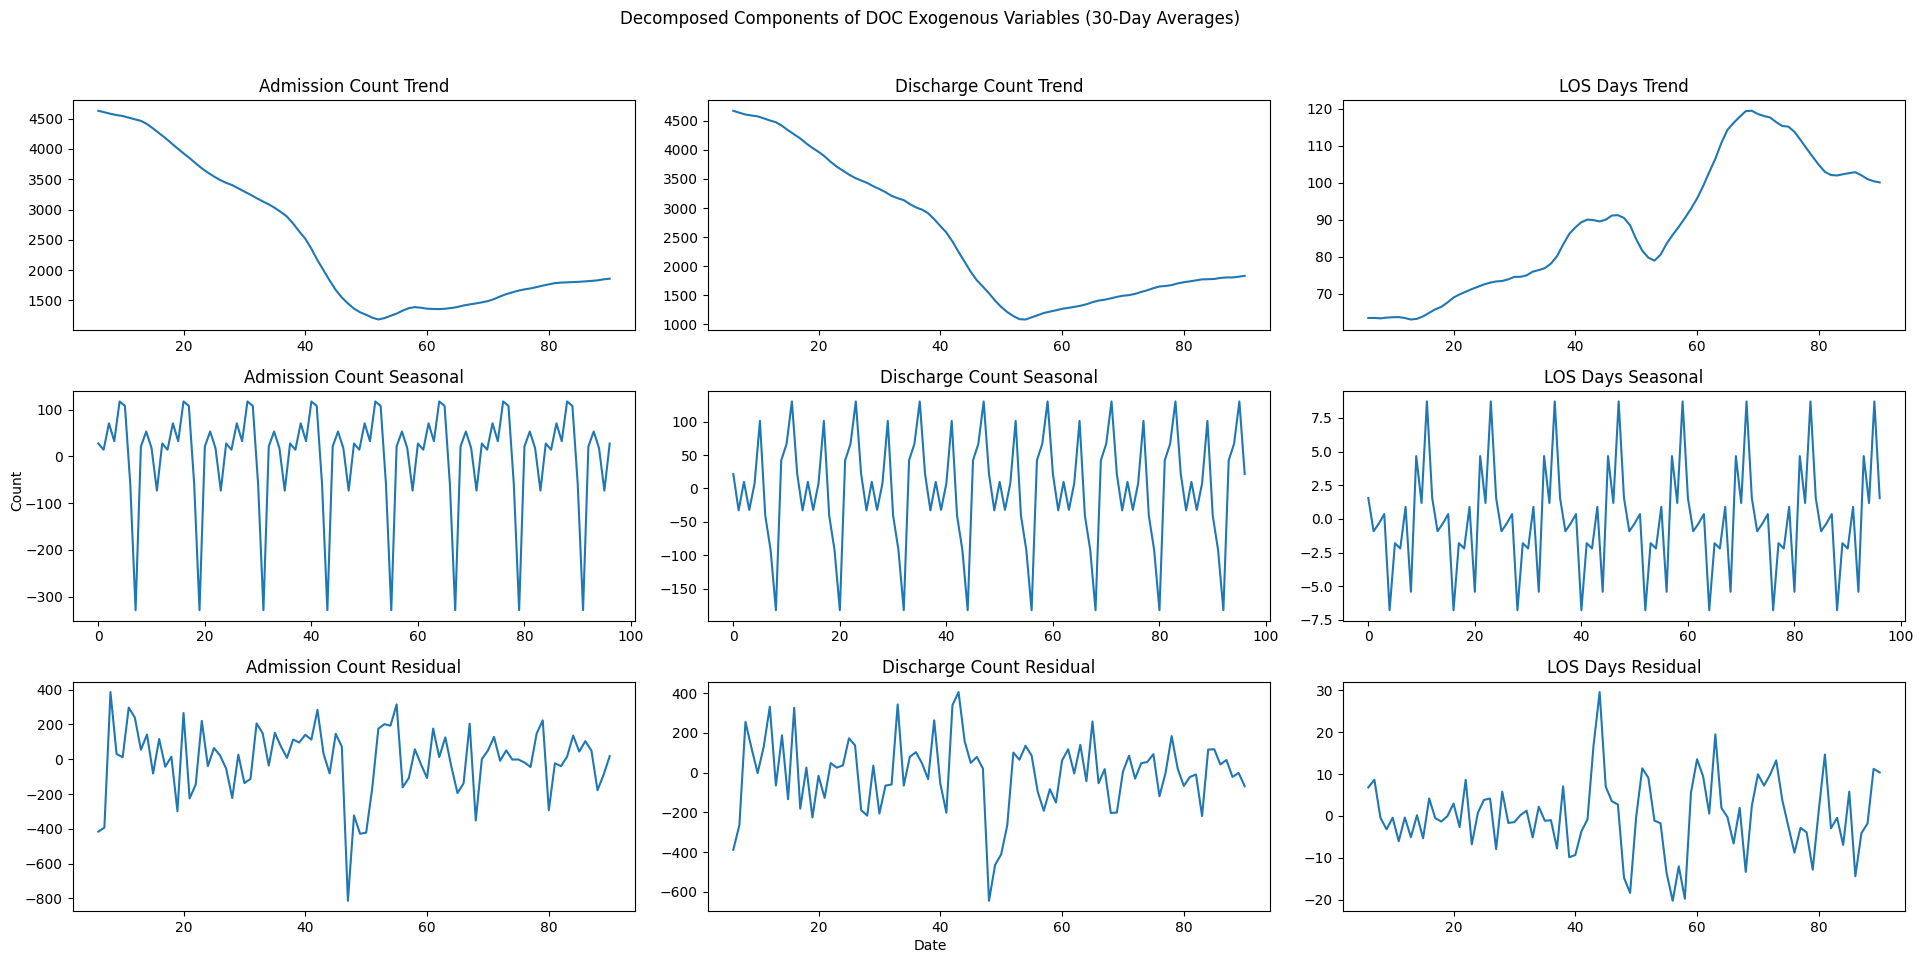

In [15]:
# Decompose the signals
admission_decomposition = seasonal_decompose(joined_doc_ivs_df['admission_count'], model='additive', period=12)
discharge_decomposition = seasonal_decompose(joined_doc_ivs_df['discharge_count'], model='additive', period=12)
los_days_decomposition = seasonal_decompose(joined_doc_ivs_df['Avg LOS Days'], model='additive', period=12)

# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(3, 3, figure=fig)

# Define components and titles
components = ['trend', 'seasonal', 'resid']
titles = ['Trend', 'Seasonal', 'Residual']

# Plot the decomposed components for admission_count, discharge_count, and los_days
decompositions = [admission_decomposition, discharge_decomposition, los_days_decomposition]
decomposition_titles = ['Admission Count', 'Discharge Count', 'LOS Days']

for i, decomposition in enumerate(decompositions):
    for j, component in enumerate(components):
        ax = fig.add_subplot(gs[j, i % 3])
        ax.plot(decomposition.trend.index, getattr(decomposition, component), label=f'{decomposition_titles[i]} {titles[j]}')
        ax.set_title(f'{decomposition_titles[i]} {titles[j]}')

# Set a common xlabel and ylabel
fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')

# Add a legend and title
fig.suptitle('Decomposed Components of DOC Exogenous Variables (30-Day Averages)')

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig('../Outputs/doc_exog_decomposed_components_plots_30days.png', bbox_inches='tight')
plt.show()

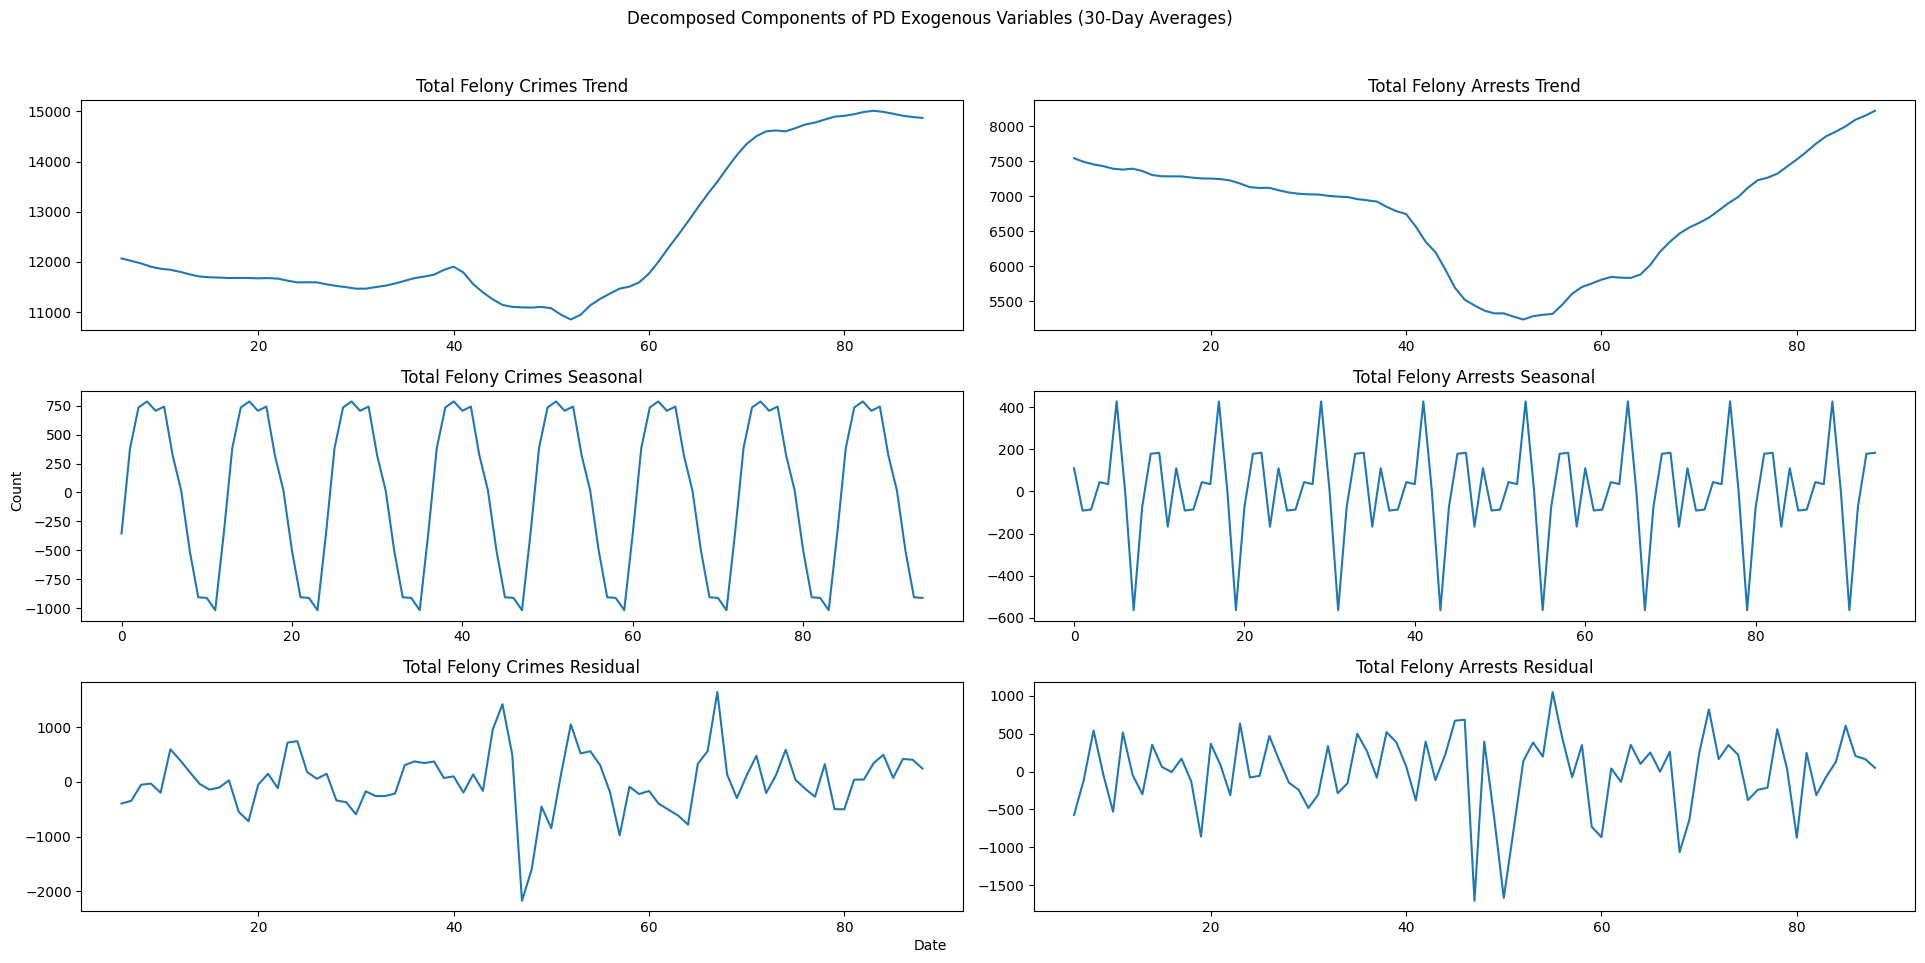

In [16]:
#Repeat for crime and arrests
# Decompose the signals
felony_crimes_decomposition = seasonal_decompose(crime_data['total_felony_crimes'], model='additive', period=12)
felony_arrest_decomposition = seasonal_decompose(arrest_data['total_felony_arrest'], model='additive', period=12)

# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Define components and titles
components = ['trend', 'seasonal', 'resid']
titles = ['Trend', 'Seasonal', 'Residual']

# Plot the decomposed components for admission_count, discharge_count, and los_days
decompositions = [felony_crimes_decomposition, felony_arrest_decomposition]
decomposition_titles = ['Total Felony Crimes', 'Total Felony Arrests']

for i, decomposition in enumerate(decompositions):
    for j, component in enumerate(components):
        ax = fig.add_subplot(gs[j, i % 3])
        ax.plot(decomposition.trend.index, getattr(decomposition, component), label=f'{decomposition_titles[i]} {titles[j]}')
        ax.set_title(f'{decomposition_titles[i]} {titles[j]}')

# Set a common xlabel and ylabel
fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')

# Add a legend and title
fig.suptitle('Decomposed Components of PD Exogenous Variables (30-Day Averages)')

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig('../Outputs/pd_exog_decomposed_components_plots_30days.png', bbox_inches='tight')
plt.show()

Determine stationality of signal

In [58]:
from pmdarima.arima.utils import ndiffs

In [18]:
for col in joined_doc_ivs_df.columns[2:]:
    print(f'The optimal d coefficient for {col} signal with alpha = 0.05 is: ', ndiffs(joined_doc_ivs_df[col], test='adf'))
    print(f'The optimal d coefficient for {col} signal with alpha = 0.025 is: ', ndiffs(joined_doc_ivs_df[col], test='adf', alpha = 0.025))

The optimal d coefficient for admission_count signal with alpha = 0.05 is:  1
The optimal d coefficient for admission_count signal with alpha = 0.025 is:  1
The optimal d coefficient for discharge_count signal with alpha = 0.05 is:  1
The optimal d coefficient for discharge_count signal with alpha = 0.025 is:  1
The optimal d coefficient for Avg LOS Days signal with alpha = 0.05 is:  1
The optimal d coefficient for Avg LOS Days signal with alpha = 0.025 is:  1


In [19]:
for col in crime_data.columns[2:]:
    print(f'The optimal d coefficient for {col} signal with alpha = 0.05 is: ', ndiffs(crime_data[col], test='adf'))
    print(f'The optimal d coefficient for {col} signal with alpha = 0.025 is: ', ndiffs(crime_data[col], test='adf', alpha = 0.025))
    print()

The optimal d coefficient for total_felony_crimes signal with alpha = 0.05 is:  1
The optimal d coefficient for total_felony_crimes signal with alpha = 0.025 is:  1

The optimal d coefficient for murder_homicide_count signal with alpha = 0.05 is:  0
The optimal d coefficient for murder_homicide_count signal with alpha = 0.025 is:  1

The optimal d coefficient for robbery_count signal with alpha = 0.05 is:  0
The optimal d coefficient for robbery_count signal with alpha = 0.025 is:  0

The optimal d coefficient for assault_count signal with alpha = 0.05 is:  0
The optimal d coefficient for assault_count signal with alpha = 0.025 is:  0

The optimal d coefficient for burglary_count signal with alpha = 0.05 is:  1
The optimal d coefficient for burglary_count signal with alpha = 0.025 is:  1

The optimal d coefficient for rape_count signal with alpha = 0.05 is:  0
The optimal d coefficient for rape_count signal with alpha = 0.025 is:  1

The optimal d coefficient for grand_larceny_count si

In [20]:
for col in arrest_data.columns[2:]:
    print(f'The optimal d coefficient for {col} signal with alpha = 0.05 is: ', ndiffs(arrest_data[col], test='adf'))
    print(f'The optimal d coefficient for {col} signal with alpha = 0.025 is: ', ndiffs(arrest_data[col], test='adf', alpha = 0.025))
    print()

The optimal d coefficient for total_felony_arrest signal with alpha = 0.05 is:  1
The optimal d coefficient for total_felony_arrest signal with alpha = 0.025 is:  1

The optimal d coefficient for arrest_murder_homicide_count signal with alpha = 0.05 is:  1
The optimal d coefficient for arrest_murder_homicide_count signal with alpha = 0.025 is:  1

The optimal d coefficient for arrest_robbery_count signal with alpha = 0.05 is:  1
The optimal d coefficient for arrest_robbery_count signal with alpha = 0.025 is:  1

The optimal d coefficient for arrest_assault_count signal with alpha = 0.05 is:  1
The optimal d coefficient for arrest_assault_count signal with alpha = 0.025 is:  1

The optimal d coefficient for arrest_burglary_count signal with alpha = 0.05 is:  0
The optimal d coefficient for arrest_burglary_count signal with alpha = 0.025 is:  1

The optimal d coefficient for arrest_rape_count signal with alpha = 0.05 is:  1
The optimal d coefficient for arrest_rape_count signal with alph

Based on the outputs above, some of these signals are stationary but the majority of them are not.

## Step 3: Fit ARIMA models using auto_arima method

* DOC exogenous variables: We will use auto_arima package to find the optimal fit for these variables. This will help us:

    * inform the methods we are using to approximate the final 30-day periods in the functions get_adm_dis_data(). Currently, we are using the average of the prior two periods to approximate the final period, if the final period contains less than 30 days worth of data points. Fitting an ARIMA model to these variables will help us determine if we should be using an autoregressive or moving average approach for approximation

    * predict 12 future data points that will be inputs to the final ADP SARIMAX model

* NYPD exogenous variables: Since this data is not updates are recently as the DOC dataset (e.g., the latest PD data was published April 22, 2024 vs. DOC is published at the end/beginning of each month), we need to fill in any missing data to ensure we have the same number of data points across all datasets, ADP, DOC exogenous and PD exogneous. Therefore, we will use auto_arima package to find the optimal fit for these variables and use them to predict any missing values. We will also use the model to predict 12 future data points that will be inputs to the final ADP SARIMAX model.

In [26]:
#fit and store the SARIMA coefficients for DOC data

result_dict = {}

for col in joined_doc_ivs_df.columns[2:]:
    # Fit a simple auto_arima model
    #let's exclude that final data point (the one we approximated in the built in function)
    print(f'Computing the optimal ARIMA model for {col}')
    auto_arima = pm.auto_arima(joined_doc_ivs_df[col], error_action='ignore', trace=True,
                        suppress_warnings=True, maxiter=5, d = ndiffs(joined_doc_ivs_df[col], test='adf'),
                        seasonal=True, m=12)
    print(auto_arima.get_params())
    
    #in sample
    in_sample = auto_arima.predict_in_sample()
    #compute IS mae
    IS_MAE = mean_absolute_error(joined_doc_ivs_df[col],in_sample)

    #store results in dictionary
    result_dict[col] = {'order':auto_arima.get_params()['order'],'seasonal_order':auto_arima.get_params()['seasonal_order'], 'IS_MEA':IS_MAE.round(2)}
result_dict

Computing the optimal ARIMA model for admission_count
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1333.343, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1360.824, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1338.628, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1342.012, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1359.983, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1339.270, Time=0.25 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1333.879, Time=0.24 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=1337.417, Time=0.47 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=1336.205, Time=0.48 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1349.980, Time=0.09 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=1336.767, Time=0.42 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=1334.789, Time=0.46 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=1338.016, Time=0.59 sec
 ARIMA(1,1,2)(1,0,1)[12] interce

{'admission_count': {'order': (2, 1, 2),
  'seasonal_order': (1, 0, 1, 12),
  'IS_MEA': 209.66},
 'discharge_count': {'order': (0, 1, 1),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 229.17},
 'Avg LOS Days': {'order': (1, 1, 0),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 7.96}}

In [27]:
#do the same for PD data
for col in crime_data.columns[2:]:
    # Fit a simple auto_arima model
    print(f'Computing the optimal ARIMA model for {col}')
    auto_arima = pm.auto_arima(crime_data[col], error_action='ignore', trace=True,
                        suppress_warnings=True, maxiter=5, d = ndiffs(crime_data[col], test='adf'),
                        seasonal=True, m=12) 
    #in sample
    in_sample = auto_arima.predict_in_sample()
    #compute IS mae
    IS_MAE = mean_absolute_error(crime_data[col],in_sample)

    #store results in dictionary
    result_dict[col] = {'order':auto_arima.get_params()['order'],'seasonal_order':auto_arima.get_params()['seasonal_order'], 'IS_MEA':IS_MAE.round(2)}
result_dict

Computing the optimal ARIMA model for total_felony_crimes
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1502.982, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1499.136, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1496.072, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1496.609, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1497.163, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1499.293, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1497.751, Time=0.25 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1497.059, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1496.581, Time=0.15 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1498.771, Time=0.36 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1494.697, Time=0.12 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1496.293, Time=0.20 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1494.928, Time=0.16 sec
 ARIMA(0,1,0)(0,0,1)[12] int

{'admission_count': {'order': (2, 1, 2),
  'seasonal_order': (1, 0, 1, 12),
  'IS_MEA': 209.66},
 'discharge_count': {'order': (0, 1, 1),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 229.17},
 'Avg LOS Days': {'order': (1, 1, 0),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 7.96},
 'total_felony_crimes': {'order': (0, 1, 0),
  'seasonal_order': (1, 0, 0, 12),
  'IS_MEA': 619.35},
 'murder_homicide_count': {'order': (2, 0, 0),
  'seasonal_order': (0, 0, 1, 12),
  'IS_MEA': 6.06},
 'robbery_count': {'order': (2, 0, 0),
  'seasonal_order': (1, 0, 0, 12),
  'IS_MEA': 70.16},
 'assault_count': {'order': (1, 0, 0),
  'seasonal_order': (2, 0, 0, 12),
  'IS_MEA': 109.74},
 'burglary_count': {'order': (1, 1, 0),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 82.38},
 'rape_count': {'order': (5, 0, 0),
  'seasonal_order': (0, 0, 2, 12),
  'IS_MEA': 12.11},
 'grand_larceny_count': {'order': (0, 1, 0),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 256.94},
 'grand_larceny_vehicle_count': {'or

In [28]:
#do the same for PD data
for col in arrest_data.columns[2:]:
    # Fit a simple auto_arima model
    print(f'Computing the optimal ARIMA model for {col}')
    auto_arima = pm.auto_arima(arrest_data[col], error_action='ignore', trace=True,
                        suppress_warnings=True, maxiter=5,d = ndiffs(arrest_data[col], test='adf'),
                        seasonal=True, m=12)
    #in sample
    in_sample = auto_arima.predict_in_sample()
    #compute IS mae
    IS_MAE = mean_absolute_error(arrest_data[col],in_sample)

    #store results in dictionary
    result_dict[col] = {'order':auto_arima.get_params()['order'],'seasonal_order':auto_arima.get_params()['seasonal_order'], 'IS_MEA':IS_MAE.round(2)}
result_dict

Computing the optimal ARIMA model for total_felony_arrest
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1482.938, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1503.059, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1490.083, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1480.982, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1501.074, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1483.659, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1482.996, Time=0.21 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1482.980, Time=0.31 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1481.185, Time=0.09 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1485.014, Time=0.36 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1497.902, Time=0.11 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1481.971, Time=0.15 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=1481.039, Time=0.19 sec
 ARIMA(1,1,0)(0,0,1)[12] int

{'admission_count': {'order': (2, 1, 2),
  'seasonal_order': (1, 0, 1, 12),
  'IS_MEA': 209.66},
 'discharge_count': {'order': (0, 1, 1),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 229.17},
 'Avg LOS Days': {'order': (1, 1, 0),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 7.96},
 'total_felony_crimes': {'order': (0, 1, 0),
  'seasonal_order': (1, 0, 0, 12),
  'IS_MEA': 619.35},
 'murder_homicide_count': {'order': (2, 0, 0),
  'seasonal_order': (0, 0, 1, 12),
  'IS_MEA': 6.06},
 'robbery_count': {'order': (2, 0, 0),
  'seasonal_order': (1, 0, 0, 12),
  'IS_MEA': 70.16},
 'assault_count': {'order': (1, 0, 0),
  'seasonal_order': (2, 0, 0, 12),
  'IS_MEA': 109.74},
 'burglary_count': {'order': (1, 1, 0),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 82.38},
 'rape_count': {'order': (5, 0, 0),
  'seasonal_order': (0, 0, 2, 12),
  'IS_MEA': 12.11},
 'grand_larceny_count': {'order': (0, 1, 0),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 256.94},
 'grand_larceny_vehicle_count': {'or

Now that we have the "optimal" coefficients for each variable, let's plot the model vs. actual data and the 13 predicted values (1 data point to complete the historical timeframe for ADP variable and then 1-yr prediction)

In [32]:
print(len(_30day_pop_tot),len(joined_doc_ivs_df),len(crime_data), len(arrest_data))

98 97 95 95


In [34]:
print(len(exog_combined.dropna()))
print(12 + (len(_30day_pop_tot) - len(exog_combined.dropna())))


95
15


It looks like our exogenous variables are missing an inconsistent number of data points compared to our DV. Therefore we will need to predict a different number of data points (12 + however many missing data points).

In [59]:
import matplotlib.dates as mdates

Fitting the SARIMA model to admission_count


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting the SARIMA model to discharge_count
Fitting the SARIMA model to Avg LOS Days
Fitting the SARIMA model to total_felony_crimes
Fitting the SARIMA model to murder_homicide_count
Fitting the SARIMA model to robbery_count


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fitting the SARIMA model to assault_count


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fitting the SARIMA model to burglary_count
Fitting the SARIMA model to rape_count


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fitting the SARIMA model to grand_larceny_count
Fitting the SARIMA model to grand_larceny_vehicle_count
Fitting the SARIMA model to weapons_count
Fitting the SARIMA model to total_felony_arrest
Fitting the SARIMA model to arrest_murder_homicide_count
Fitting the SARIMA model to arrest_robbery_count
Fitting the SARIMA model to arrest_assault_count
Fitting the SARIMA model to arrest_burglary_count
Fitting the SARIMA model to arrest_rape_count
Fitting the SARIMA model to arrest_grand_larceny_count
Fitting the SARIMA model to arrest_grand_larceny_vehicle_count
Fitting the SARIMA model to arrest_weapons_count


C:\Users\emjoh\AppData\Local\Temp\ipykernel_18612\315965997.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])


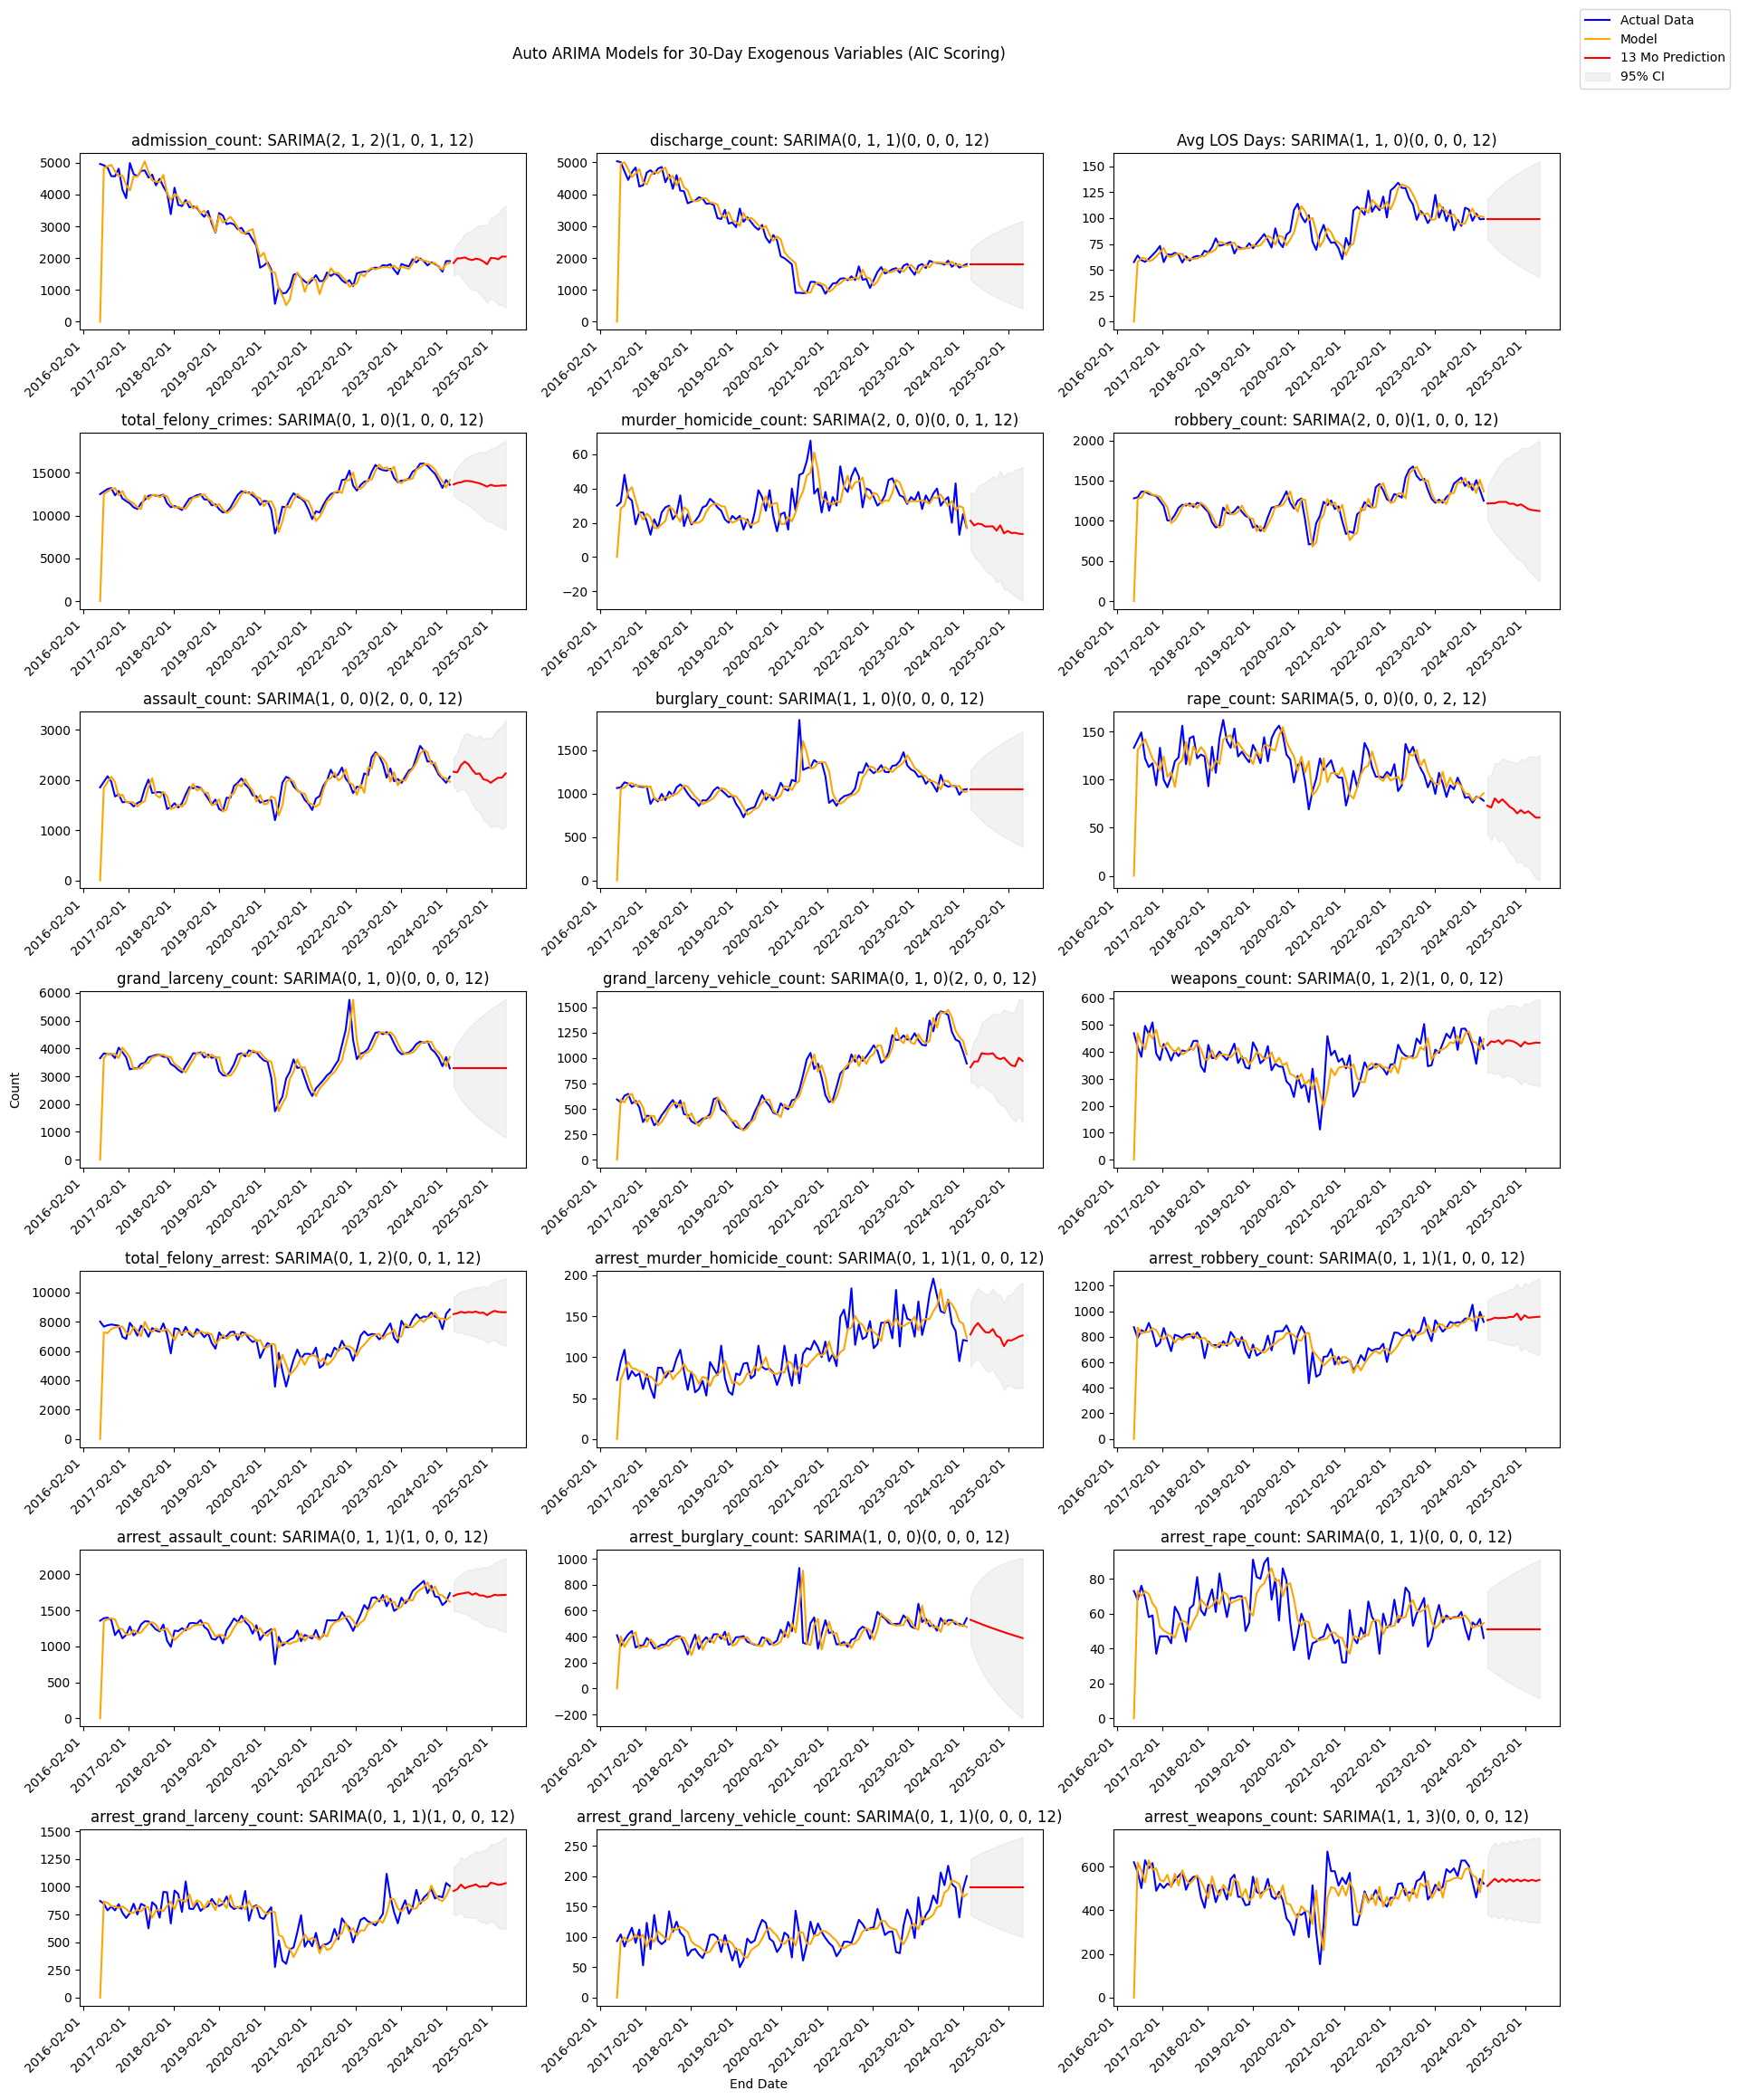

In [36]:

# Create the figure and subplots
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(18, 24), constrained_layout=True)
axes = axes.flatten()

# Define colors and labels
actual_color = 'blue'
model_color = 'orange'
forecast_color = 'red'
ci_color = 'grey'
legend_labels = ['Actual Data', 'Model', '13 Mo Prediction', '95% CI']

#add column to the dataframe storing the exogenous variables that indicates actual data vs. predicted values
#force the time periods to be consistent across the exogenous variables datasets
exog_combined = exog_combined.dropna()
exog_combined['Type'] = 'Actual Data'
# Generate future dates for forecast
last_date = exog_combined['End Date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=12+(len(_30day_pop_tot)-len(exog_combined))+1, freq='30D')[1:]

#create a df for the prediction results
exog_predictions = pd.DataFrame(columns = exog_combined.columns)
exog_predictions['Start Date'] = future_dates - pd.to_timedelta(29, unit='D')
exog_predictions['End Date'] = future_dates
exog_predictions['Type'] = 'Prediction'

# Iterate over the dictionary and plot
for idx, (var, params) in enumerate(result_dict.items()):
    if var not in exog_combined.columns:
        continue
    print(f'Fitting the SARIMA model to {var}')
    # Prepare data
    y = exog_combined[var].dropna()
    date = exog_combined['End Date'].dropna()

    # Fit the ARIMA model
    order = params['order']
    seasonal_order = params['seasonal_order']
    model = SARIMAX(y, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # Generate in-sample predictions
    y_pred = model_fit.fittedvalues
    # Generate out-of-sample forecast
    forecast = model_fit.get_forecast(steps=12+(len(_30day_pop_tot)-len(exog_combined)))
    y_forecast = forecast.predicted_mean
    #store to prediction dataframe
    exog_predictions[var] = y_forecast.values
    conf_int = forecast.conf_int()

    # Plot the results
    ax = axes[idx]
    ax.plot(date, y, color=actual_color, label=legend_labels[0])
    ax.plot(date, y_pred, color=model_color, label=legend_labels[1])
    ax.plot(future_dates, y_forecast, color=forecast_color, label=legend_labels[2])
    ax.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color=ci_color, alpha=0.1, label=legend_labels[3])
    ax.set_title(f"{var}: SARIMA{order}{seasonal_order}")
    # Set date formatting for x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Set common labels
fig.text(0.5, 0.04, 'End Date', ha='center')
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')

# Create one legend for all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='upper right', bbox_to_anchor=(1.1, 1), bbox_transform=fig.transFigure)
fig.suptitle('Auto ARIMA Models for 30-Day Exogenous Variables (AIC Scoring)')
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig('../Outputs/30_day_exog_auto_arima_plots_AIC.png', bbox_inches='tight')
plt.show()


In [37]:
exog_predictions.head()

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days,total_felony_crimes,murder_homicide_count,robbery_count,assault_count,burglary_count,...,total_felony_arrest,arrest_murder_homicide_count,arrest_robbery_count,arrest_assault_count,arrest_burglary_count,arrest_rape_count,arrest_grand_larceny_count,arrest_grand_larceny_vehicle_count,arrest_weapons_count,Type
0,2024-03-05,2024-04-03,1845.589706,1793.233467,98.932559,13639.664914,21.123268,1214.394021,2165.456047,1047.605958,...,8514.285986,127.649866,929.454923,1702.088974,530.166458,51.157733,961.501606,181.922977,510.958937,Prediction
1,2024-04-04,2024-05-03,1990.092944,1793.233467,98.971395,13823.731941,18.424231,1217.239944,2154.286833,1048.424735,...,8575.938709,136.339709,937.101716,1724.083417,518.591278,51.157733,978.308179,181.922977,528.520377,Prediction
2,2024-05-04,2024-06-02,1994.655418,1793.233467,98.956564,13888.573735,19.532396,1217.268632,2296.872725,1048.144709,...,8672.429242,141.665742,948.695241,1733.313228,507.268821,51.157733,1019.782465,181.922977,544.179531,Prediction
3,2024-06-03,2024-07-02,2021.210489,1793.233467,98.962228,14041.498109,19.141388,1233.877389,2368.468664,1048.240479,...,8602.096523,135.779074,945.241851,1742.543039,496.193568,51.157733,985.627171,181.922977,529.847987,Prediction
4,2024-07-03,2024-08-01,1967.833742,1793.233467,98.960065,14044.287003,17.733576,1234.305786,2314.019245,1048.207725,...,8664.507524,130.453041,947.955229,1751.576470,485.360122,51.157733,1001.078375,181.922977,542.964477,Prediction


In [38]:
final_exog_df = pd.concat([exog_combined,exog_predictions],ignore_index=True)
print(len(exog_combined),len(exog_predictions),len(final_exog_df))
final_exog_df.head()

95 15 110


,Start Date,End Date,admission_count,discharge_count,Avg LOS Days,total_felony_crimes,murder_homicide_count,robbery_count,assault_count,burglary_count,...,total_felony_arrest,arrest_murder_homicide_count,arrest_robbery_count,arrest_assault_count,arrest_burglary_count,arrest_rape_count,arrest_grand_larceny_count,arrest_grand_larceny_vehicle_count,arrest_weapons_count,Type
0,2016-05-16,2016-06-14,4961.0,5036.0,57.516161,12507.0,30.0,1279.0,1854.0,1063.0,...,8004.0,72.0,875.0,1357.0,411.0,73.0,872.0,93.0,620.0,Actual Data
1,2016-06-15,2016-07-14,4918.0,5011.0,63.843071,12820.0,32.0,1291.0,1966.0,1070.0,...,7661.0,94.0,791.0,1392.0,328.0,68.0,848.0,104.0,576.0,Actual Data
2,2016-07-15,2016-08-13,4846.0,4725.0,59.396913,13099.0,48.0,1362.0,2076.0,1128.0,...,7756.0,109.0,852.0,1400.0,377.0,76.0,787.0,84.0,501.0,Actual Data
3,2016-08-14,2016-09-12,4578.0,4452.0,57.784929,13224.0,35.0,1362.0,1969.0,1115.0,...,7808.0,73.0,835.0,1365.0,418.0,69.0,821.0,101.0,629.0,Actual Data
4,2016-09-13,2016-10-12,4572.0,4692.0,60.720000,12372.0,33.0,1334.0,1673.0,1076.0,...,7767.0,83.0,908.0,1157.0,444.0,58.0,787.0,115.0,593.0,Actual Data


In [39]:
final_exog_df.tail(16)

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days,total_felony_crimes,murder_homicide_count,robbery_count,assault_count,burglary_count,...,total_felony_arrest,arrest_murder_homicide_count,arrest_robbery_count,arrest_assault_count,arrest_burglary_count,arrest_rape_count,arrest_grand_larceny_count,arrest_grand_larceny_vehicle_count,arrest_weapons_count,Type
94,2024-02-04,2024-03-04,1907.000000,1809.000000,99.034254,13589.000000,17.000000,1249.000000,2070.000000,1050.000000,...,8840.000000,120.000000,916.000000,1741.000000,542.000000,46.000000,1006.000000,200.000000,522.000000,Actual Data
95,2024-03-05,2024-04-03,1845.589706,1793.233467,98.932559,13639.664914,21.123268,1214.394021,2165.456047,1047.605958,...,8514.285986,127.649866,929.454923,1702.088974,530.166458,51.157733,961.501606,181.922977,510.958937,Prediction
96,2024-04-04,2024-05-03,1990.092944,1793.233467,98.971395,13823.731941,18.424231,1217.239944,2154.286833,1048.424735,...,8575.938709,136.339709,937.101716,1724.083417,518.591278,51.157733,978.308179,181.922977,528.520377,Prediction
97,2024-05-04,2024-06-02,1994.655418,1793.233467,98.956564,13888.573735,19.532396,1217.268632,2296.872725,1048.144709,...,8672.429242,141.665742,948.695241,1733.313228,507.268821,51.157733,1019.782465,181.922977,544.179531,Prediction
98,2024-06-03,2024-07-02,2021.210489,1793.233467,98.962228,14041.498109,19.141388,1233.877389,2368.468664,1048.240479,...,8602.096523,135.779074,945.241851,1742.543039,496.193568,51.157733,985.627171,181.922977,529.847987,Prediction
99,2024-07-03,2024-08-01,1967.833742,1793.233467,98.960065,14044.287003,17.733576,1234.305786,2314.019245,1048.207725,...,8664.507524,130.453041,947.955229,1751.576470,485.360122,51.157733,1001.078375,181.922977,542.964477,Prediction
100,2024-08-02,2024-08-31,1937.491946,1793.233467,98.960891,13983.860959,17.866406,1234.968282,2206.303506,1048.218927,...,8630.235868,129.892406,947.215217,1718.192048,474.763204,51.157733,1009.752736,181.922977,530.960027,Prediction
101,2024-09-01,2024-09-30,1983.590527,1793.233467,98.960575,13867.889435,17.966763,1209.429943,2121.870063,1048.215096,...,8689.422202,134.377486,954.862010,1738.419080,464.397649,51.157733,1021.408908,181.922977,541.946719,Prediction
102,2024-10-01,2024-10-30,1959.212104,1793.233467,98.960696,13765.397568,15.416229,1212.531933,2132.207404,1048.216406,...,8590.516185,126.248279,954.862010,1708.962237,454.258407,51.157733,998.638712,181.922977,531.891498,Prediction
103,2024-10-31,2024-11-29,1897.017003,1793.233467,98.960650,13589.929631,18.557407,1187.801963,2014.743150,1048.215958,...,8619.634978,123.725421,981.749122,1707.194827,444.340536,51.157733,1004.331261,181.922977,541.094219,Prediction


In [40]:
#save to csv
final_exog_df.to_csv("../Data/30_day_exog_combined_actual_13_mo_prediction.csv")

In [44]:
#save the result dictionary to a json object for future use
# import json module
import json  
     
with open("../Data/30_day_exog_ARIMA_models.json", 'w') as fp:
    json.dump(result_dict, fp)


# Determine relationship between Criminal Legal Exogenous Variables

The criminal-legal system has a well defined procedure. Someone commits a crime, then arrested, arraigned and proscecuted in the court, either detained or not in DOC custody. Therefore, the crime, arrest, and DOC variables have a relationship with one another in this respective order and will will use crime to predict arrests, which will then predict DOC variables, which will then predict ADP.

In [143]:
#feed the crime data into the arrest data using the optimal order defined above. 
#print the summary to see significance and model performance indicators

#import the dictionary and use the key to get the order and seasonal order 
# Opening JSON file
with open("../Data/30_day_exog_ARIMA_models.json") as json_file:
    arima_dict = json.load(json_file)

print(arima_dict['total_felony_arrest'])

{'order': [0, 1, 2], 'seasonal_order': [0, 0, 1, 12], 'IS_MEA': 522.46}


In [144]:
exog_combined.columns

Index(['Start Date', 'End Date', 'admission_count', 'discharge_count',
       'Avg LOS Days', 'total_felony_crimes', 'murder_homicide_count',
       'robbery_count', 'assault_count', 'burglary_count', 'rape_count',
       'grand_larceny_count', 'grand_larceny_vehicle_count', 'weapons_count',
       'total_felony_arrest', 'arrest_murder_homicide_count',
       'arrest_robbery_count', 'arrest_assault_count', 'arrest_burglary_count',
       'arrest_rape_count', 'arrest_grand_larceny_count',
       'arrest_grand_larceny_vehicle_count', 'arrest_weapons_count'],
      dtype='object')

In [163]:
# Prepare data
y = exog_combined['total_felony_arrest'].dropna()
var_ls = ['total_felony_crimes', 'murder_homicide_count',
          'robbery_count', 'assault_count', 'burglary_count', 'rape_count',
          'grand_larceny_count', 'grand_larceny_vehicle_count', 'weapons_count'
          ]
exog = exog_combined[var_ls].dropna()
date = exog_combined['End Date'].dropna()

# Fit the ARIMA model
order = arima_dict['total_felony_arrest']['order']
seasonal_order = arima_dict['total_felony_arrest']['seasonal_order']
model = SARIMAX(y, order=order, seasonal_order=seasonal_order, exog = exog)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                  total_felony_arrest   No. Observations:                   95
Model:             SARIMAX(0, 1, 2)x(0, 0, [1], 12)   Log Likelihood                -664.453
Date:                              Mon, 10 Jun 2024   AIC                           1354.905
Time:                                      18:12:28   BIC                           1387.968
Sample:                                           0   HQIC                          1368.260
                                               - 95                                         
Covariance Type:                                opg                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
total_felony_crimes             1.6895      0.181      9.358    

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


It looks like the count of rape crime complaints is the only variable that is not statistically significant to predict total felony arrests.

In [164]:
# Prepare data
y = exog_combined['total_felony_arrest'].dropna()
var_ls = ['total_felony_crimes', 'murder_homicide_count',
          'robbery_count', 'assault_count', 'burglary_count', 
          'grand_larceny_count', 'grand_larceny_vehicle_count', 'weapons_count'
          ]
exog = exog_combined[var_ls].dropna()
date = exog_combined['End Date'].dropna()

# Fit the ARIMA model
order = arima_dict['total_felony_arrest']['order']
seasonal_order = arima_dict['total_felony_arrest']['seasonal_order']
model = SARIMAX(y, order=order, seasonal_order=seasonal_order, exog = exog)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                  total_felony_arrest   No. Observations:                   95
Model:             SARIMAX(0, 1, 2)x(0, 0, [1], 12)   Log Likelihood                -665.238
Date:                              Mon, 10 Jun 2024   AIC                           1354.476
Time:                                      18:12:30   BIC                           1384.995
Sample:                                           0   HQIC                          1366.803
                                               - 95                                         
Covariance Type:                                opg                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
total_felony_crimes             1.6370      0.176      9.300    

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [165]:
#use the predicted results from these crime counts to predict the future felony arrest counts
#import the predictions
final_exog_df = pd.read_csv("../Data/30_day_exog_combined_actual_13_mo_prediction.csv", index_col=0)
print(final_exog_df.shape)

(110, 24)


In [166]:
print(len(_30day_pop_tot),len(exog_combined.dropna()))

98 95


(15, 8)


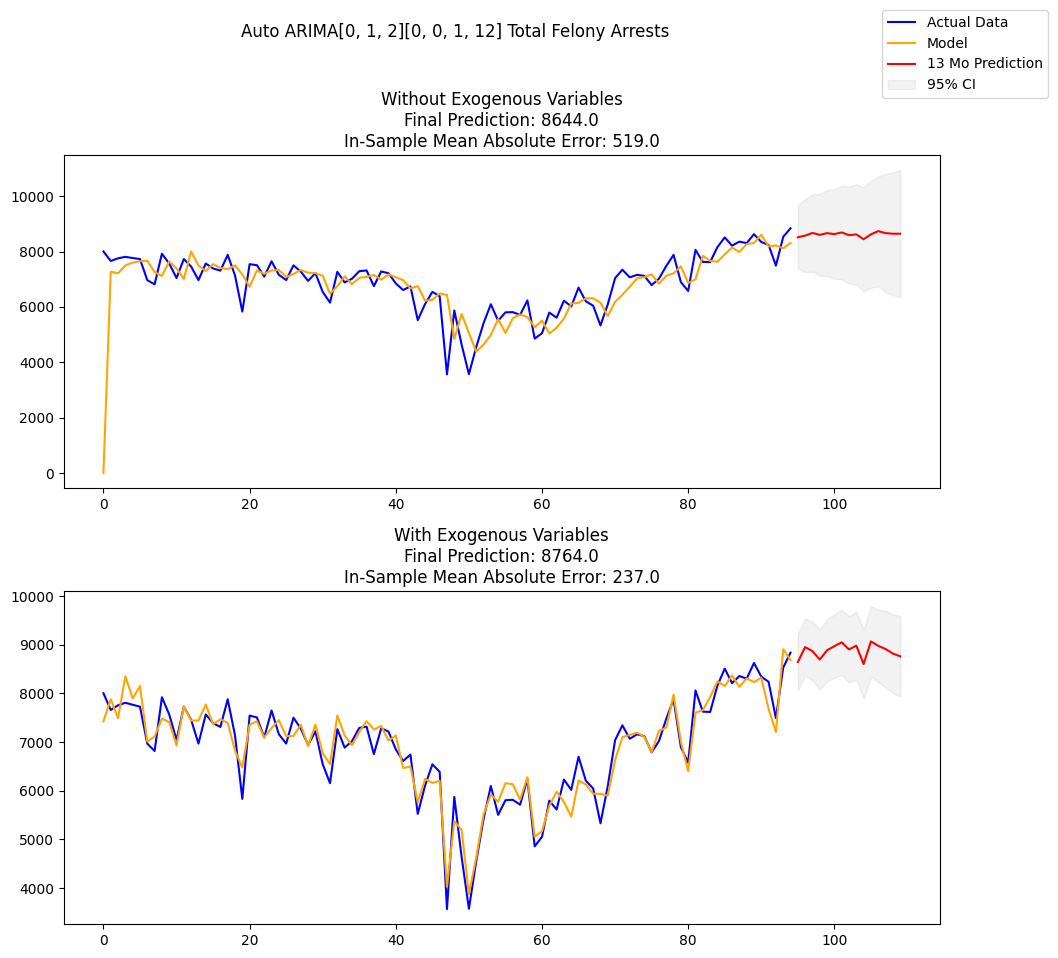

In [167]:
actual_color = 'blue'
model_color = 'orange'
forecast_color = 'red'
ci_color = 'grey'
legend_labels = ['Actual Data', 'Model', '13 Mo Prediction', '95% CI']

#predict
exog_pred = final_exog_df[final_exog_df['Type'] == 'Prediction'][var_ls]
print(exog_pred.shape)
n_steps = 12+(len(_30day_pop_tot)-len(exog_combined.dropna()))
# Generate in-sample predictions
y_pred_exog = model_fit.fittedvalues
# Generate out-of-sample forecast_exog
forecast_exog = model_fit.get_forecast(steps=n_steps, exog = exog_pred)
y_forecast_exog = forecast_exog.predicted_mean
conf_int_exog = forecast_exog.conf_int()
#in sample error
IS_mae_exog = mean_absolute_error(y, y_pred_exog)

#without exog
model_no_exog = SARIMAX(y, order=order, seasonal_order=seasonal_order)
model_fit_no_exog = model_no_exog.fit(disp=False)
# Generate in-sample predictions
y_pred = model_fit_no_exog.fittedvalues
forecast = model_fit_no_exog.get_forecast(steps=n_steps)
y_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()
#in sample error
IS_mae = mean_absolute_error(y, y_pred)

# Plot the results
fig, ax = plt.subplots(2,1,figsize = (10,10))
#without exog
ax[0].plot(y.index, y, color=actual_color, label=legend_labels[0])
ax[0].plot(y.index, y_pred, color=model_color, label=legend_labels[1])
ax[0].plot(np.arange(len(y),len(y)+n_steps), y_forecast, color=forecast_color, label=legend_labels[2]) 
ax[0].fill_between(np.arange(len(y),len(y)+n_steps), conf_int.iloc[:, 0], conf_int.iloc[:, 1], color=ci_color, alpha=0.1, label=legend_labels[3])
ax[0].set_title(f"Without Exogenous Variables\nFinal Prediction: {y_forecast.iloc[-1].round()}\nIn-Sample Mean Absolute Error: {IS_mae.round()}")
#with exog
ax[1].plot(y.index, y, color=actual_color, label=legend_labels[0])
ax[1].plot(y.index, y_pred_exog, color=model_color, label=legend_labels[1])
ax[1].plot(np.arange(len(y),len(y)+n_steps), y_forecast_exog, color=forecast_color, label=legend_labels[2]) 
ax[1].fill_between(np.arange(len(y),len(y)+n_steps), conf_int_exog.iloc[:, 0], conf_int_exog.iloc[:, 1], color=ci_color, alpha=0.1, label=legend_labels[3])
ax[1].set_title(f"With Exogenous Variables\nFinal Prediction: {y_forecast_exog.iloc[-1].round()}\nIn-Sample Mean Absolute Error: {IS_mae_exog.round()}")
# Create one legend for all subplots
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='upper right', bbox_to_anchor=(1.1, 1), bbox_transform=fig.transFigure)
fig.suptitle(f"Auto ARIMA{order}{seasonal_order} Total Felony Arrests")
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig("../Outputs/felony_arrest_SARIMAX_comparing_exog_outputs.png", bbox_inches = 'tight')
plt.show()

In [168]:
#store these newly predicted values in the dataframe/csv to use in the model training script
final_exog_df['total_felony_arrest_exog'] = pd.concat([final_exog_df[final_exog_df['Type'] == 'Actual Data']['total_felony_arrest'],y_forecast_exog], ignore_index=True)

Based on the results above, we should go with the model trained on the exogenous crime variables because the in-sample predictions are much closer to the actual data and the CI of our predictions are smaller as well. Now we can use The predicted felony arrests outputed by this model in the DOC admission ARIMA model.

In [170]:
#define exog variables for this model
felony_arrest_exog = exog_combined['total_felony_arrest'].dropna()
felony_arrest_exog_pred = y_forecast_exog
y = exog_combined['admission_count'].dropna()
print(len(_30day_pop_tot),len(y),len(felony_arrest_exog),len(felony_arrest_exog_pred))

98 96 95 15


Recall that we have 98 periods for ADP time series. We only had 95 periods for the arrest and crime data, therefore we predicted 15 periods (3 to fill missing data and 12 future predictions). 

DOC data has 96 periods. Therefore, we will need to predict 14 periods (2 to fill missing data and 12 future predictions). We must use the first value from the `felony_arrest_exog_pred` array with the 95 *actual* felony arrest data points to train the admission SARIMAX model. Then we will use the following 14 predicted values of felony arrest counts to predict the 14 admission counts.

In [171]:
felony_arrest_exog.at[len(felony_arrest_exog)] = y_forecast_exog.iloc[0].round()

In [172]:
felony_arrest_exog_pred = felony_arrest_exog_pred.iloc[1:]
print(len(felony_arrest_exog_pred))

14


In [173]:
#get order for DOC admission
order = arima_dict['admission_count']['order']
seasonal_order = arima_dict['admission_count']['seasonal_order']
model_exog = SARIMAX(y, order=order, seasonal_order=seasonal_order, exog = felony_arrest_exog)
model_fit_exog = model_exog.fit(disp=False)

print(model_fit_exog.summary())

                                      SARIMAX Results                                       
Dep. Variable:                      admission_count   No. Observations:                   96
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -622.641
Date:                              Mon, 10 Jun 2024   AIC                           1261.282
Time:                                      18:13:09   BIC                           1281.713
Sample:                                           0   HQIC                          1269.538
                                               - 96                                         
Covariance Type:                                opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
total_felony_arrest     0.2676      0.026     10.134      0.000       0.216     

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


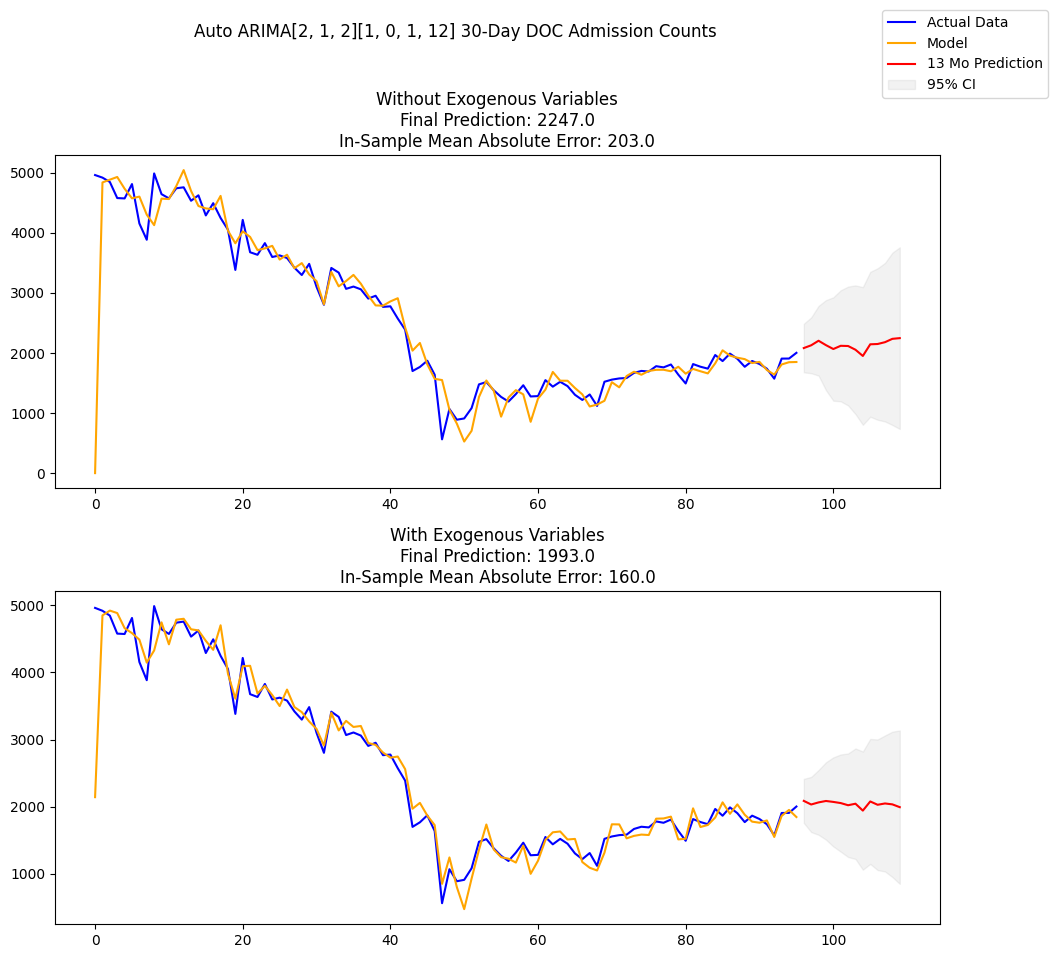

In [174]:
n_steps = len(felony_arrest_exog_pred)
# Generate in-sample predictions
y_pred_exog = model_fit_exog.fittedvalues
# Generate out-of-sample forecast_exog
forecast_exog = model_fit_exog.get_forecast(steps=n_steps, exog = felony_arrest_exog_pred)
y_forecast_exog = forecast_exog.predicted_mean
conf_int_exog = forecast_exog.conf_int()
#in sample error
IS_mae_exog = mean_absolute_error(y, y_pred_exog)

#without exog
model_no_exog = SARIMAX(y, order=order, seasonal_order=seasonal_order)
model_fit_no_exog = model_no_exog.fit(disp=False)
# Generate in-sample predictions
y_pred = model_fit_no_exog.fittedvalues
forecast = model_fit_no_exog.get_forecast(steps=n_steps)
y_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()
#in sample error
IS_mae = mean_absolute_error(y, y_pred)

# Plot the results
fig, ax = plt.subplots(2,1,figsize = (10,10))
#without exog
ax[0].plot(y.index, y, color=actual_color, label=legend_labels[0])
ax[0].plot(y.index, y_pred, color=model_color, label=legend_labels[1])
ax[0].plot(np.arange(len(y),len(y)+n_steps), y_forecast, color=forecast_color, label=legend_labels[2]) 
ax[0].fill_between(np.arange(len(y),len(y)+n_steps), conf_int.iloc[:, 0], conf_int.iloc[:, 1], color=ci_color, alpha=0.1, label=legend_labels[3])
ax[0].set_title(f"Without Exogenous Variables\nFinal Prediction: {y_forecast.iloc[-1].round()}\nIn-Sample Mean Absolute Error: {IS_mae.round()}")
#with exog
ax[1].plot(y.index, y, color=actual_color, label=legend_labels[0])
ax[1].plot(y.index, y_pred_exog, color=model_color, label=legend_labels[1])
ax[1].plot(np.arange(len(y),len(y)+n_steps), y_forecast_exog, color=forecast_color, label=legend_labels[2]) 
ax[1].fill_between(np.arange(len(y),len(y)+n_steps), conf_int_exog.iloc[:, 0], conf_int_exog.iloc[:, 1], color=ci_color, alpha=0.1, label=legend_labels[3])
ax[1].set_title(f"With Exogenous Variables\nFinal Prediction: {y_forecast_exog.iloc[-1].round()}\nIn-Sample Mean Absolute Error: {IS_mae_exog.round()}")
# Create one legend for all subplots
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='upper right', bbox_to_anchor=(1.1, 1), bbox_transform=fig.transFigure)
fig.suptitle(f"Auto ARIMA{order}{seasonal_order} 30-Day DOC Admission Counts")
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig("../Outputs/admission_count_SARIMAX_comparing_exog_outputs.png", bbox_inches = 'tight')
plt.show()

In [175]:
#store these newly predicted values in the dataframe/csv to use in the model training script
final_exog_df['admission_count_exog'] = pd.concat([final_exog_df[final_exog_df['Type'] == 'Actual Data']['admission_count'],y_forecast_exog], ignore_index=True)

In [176]:
final_exog_df.head()

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days,total_felony_crimes,murder_homicide_count,robbery_count,assault_count,burglary_count,...,arrest_robbery_count,arrest_assault_count,arrest_burglary_count,arrest_rape_count,arrest_grand_larceny_count,arrest_grand_larceny_vehicle_count,arrest_weapons_count,Type,total_felony_arrest_exog,admission_count_exog
0,2016-05-16,2016-06-14,4961.0,5036.0,57.516161,12507.0,30.0,1279.0,1854.0,1063.0,...,875.0,1357.0,411.0,73.0,872.0,93.0,620.0,Actual Data,8004.0,4961.0
1,2016-06-15,2016-07-14,4918.0,5011.0,63.843071,12820.0,32.0,1291.0,1966.0,1070.0,...,791.0,1392.0,328.0,68.0,848.0,104.0,576.0,Actual Data,7661.0,4918.0
2,2016-07-15,2016-08-13,4846.0,4725.0,59.396913,13099.0,48.0,1362.0,2076.0,1128.0,...,852.0,1400.0,377.0,76.0,787.0,84.0,501.0,Actual Data,7756.0,4846.0
3,2016-08-14,2016-09-12,4578.0,4452.0,57.784929,13224.0,35.0,1362.0,1969.0,1115.0,...,835.0,1365.0,418.0,69.0,821.0,101.0,629.0,Actual Data,7808.0,4578.0
4,2016-09-13,2016-10-12,4572.0,4692.0,60.720000,12372.0,33.0,1334.0,1673.0,1076.0,...,908.0,1157.0,444.0,58.0,787.0,115.0,593.0,Actual Data,7767.0,4572.0


In [177]:
final_exog_df.tail(16)

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days,total_felony_crimes,murder_homicide_count,robbery_count,assault_count,burglary_count,...,arrest_robbery_count,arrest_assault_count,arrest_burglary_count,arrest_rape_count,arrest_grand_larceny_count,arrest_grand_larceny_vehicle_count,arrest_weapons_count,Type,total_felony_arrest_exog,admission_count_exog
94,2024-02-04,2024-03-04,1907.000000,1809.000000,99.034254,13589.000000,17.000000,1249.000000,2070.000000,1050.000000,...,916.000000,1741.000000,542.000000,46.000000,1006.000000,200.000000,522.000000,Actual Data,8840.000000,1907.000000
95,2024-03-05,2024-04-03,1845.589706,1793.233467,98.932559,13639.664914,21.123268,1214.394021,2165.456047,1047.605958,...,929.454923,1702.088974,530.166458,51.157733,961.501606,181.922977,510.958937,Prediction,8644.619308,2086.026721
96,2024-04-04,2024-05-03,1990.092944,1793.233467,98.971395,13823.731941,18.424231,1217.239944,2154.286833,1048.424735,...,937.101716,1724.083417,518.591278,51.157733,978.308179,181.922977,528.520377,Prediction,8953.853510,2032.355462
97,2024-05-04,2024-06-02,1994.655418,1793.233467,98.956564,13888.573735,19.532396,1217.268632,2296.872725,1048.144709,...,948.695241,1733.313228,507.268821,51.157733,1019.782465,181.922977,544.179531,Prediction,8869.824917,2063.555234
98,2024-06-03,2024-07-02,2021.210489,1793.233467,98.962228,14041.498109,19.141388,1233.877389,2368.468664,1048.240479,...,945.241851,1742.543039,496.193568,51.157733,985.627171,181.922977,529.847987,Prediction,8697.092768,2084.754328
99,2024-07-03,2024-08-01,1967.833742,1793.233467,98.960065,14044.287003,17.733576,1234.305786,2314.019245,1048.207725,...,947.955229,1751.576470,485.360122,51.157733,1001.078375,181.922977,542.964477,Prediction,8887.876162,2070.770447
100,2024-08-02,2024-08-31,1937.491946,1793.233467,98.960891,13983.860959,17.866406,1234.968282,2206.303506,1048.218927,...,947.215217,1718.192048,474.763204,51.157733,1009.752736,181.922977,530.960027,Prediction,8972.107876,2053.533437
101,2024-09-01,2024-09-30,1983.590527,1793.233467,98.960575,13867.889435,17.966763,1209.429943,2121.870063,1048.215096,...,954.862010,1738.419080,464.397649,51.157733,1021.408908,181.922977,541.946719,Prediction,9051.435219,2021.359767
102,2024-10-01,2024-10-30,1959.212104,1793.233467,98.960696,13765.397568,15.416229,1212.531933,2132.207404,1048.216406,...,954.862010,1708.962237,454.258407,51.157733,998.638712,181.922977,531.891498,Prediction,8904.696513,2044.011434
103,2024-10-31,2024-11-29,1897.017003,1793.233467,98.960650,13589.929631,18.557407,1187.801963,2014.743150,1048.215958,...,981.749122,1707.194827,444.340536,51.157733,1004.331261,181.922977,541.094219,Prediction,8982.076624,1941.387727
